In [28]:
# Fraud detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/content/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [3]:
print("Shape of dataset:", df.shape)

Shape of dataset: (517898, 11)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517898 entries, 0 to 517897
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            517898 non-null  int64  
 1   type            517898 non-null  object 
 2   amount          517898 non-null  float64
 3   nameOrig        517898 non-null  object 
 4   oldbalanceOrg   517898 non-null  float64
 5   newbalanceOrig  517898 non-null  float64
 6   nameDest        517898 non-null  object 
 7   oldbalanceDest  517898 non-null  float64
 8   newbalanceDest  517897 non-null  float64
 9   isFraud         517897 non-null  float64
 10  isFlaggedFraud  517897 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 43.5+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,517898.000000,5.178980e+05,5.178980e+05,5.178980e+05,5.178980e+05,5.178970e+05,517897.000000,517897.0
mean,14.117305,1.650769e+05,9.077125e+05,9.274804e+05,9.823213e+05,1.159027e+06,0.000450,0.0
std,3.832032,2.706526e+05,3.005769e+06,3.042842e+06,2.334740e+06,2.505492e+06,0.021206,0.0
min,1.000000,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,11.000000,1.320912e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,14.000000,8.058208e+04,1.859661e+04,0.000000e+00,1.204843e+05,2.211321e+05,0.000000,0.0
75%,17.000000,2.206641e+05,1.680073e+05,2.076514e+05,8.973850e+05,1.196871e+06,0.000000,0.0
max,20.000000,1.000000e+07,3.893942e+07,3.894623e+07,4.148270e+07,4.148270e+07,1.000000,0.0


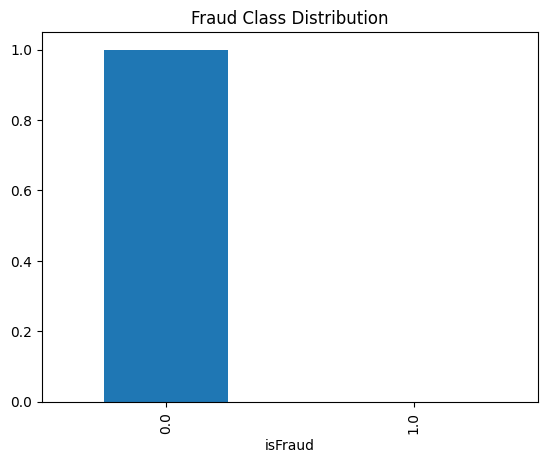

In [6]:
df['isFraud'].value_counts(normalize=True).plot(kind='bar', title='Fraud Class Distribution')
plt.show()

In [7]:
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [8]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1.0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1.0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,False,False,True,False


In [9]:
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [12]:
df.dropna(inplace=True)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_res.value_counts())


Before SMOTE: isFraud
0.0    414131
1.0       186
Name: count, dtype: int64
After SMOTE: isFraud
0.0    414131
1.0    414131
Name: count, dtype: int64


In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_res, y_res)


RandomForestClassifier(random_state=42)

In [16]:
y_pred = rf.predict(X_test)


In [17]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    103533
         1.0       0.75      0.94      0.83        47

    accuracy                           1.00    103580
   macro avg       0.87      0.97      0.92    103580
weighted avg       1.00      1.00      1.00    103580

Confusion Matrix:
 [[103518     15]
 [     3     44]]


ROC-AUC Score: 0.9780472913251423


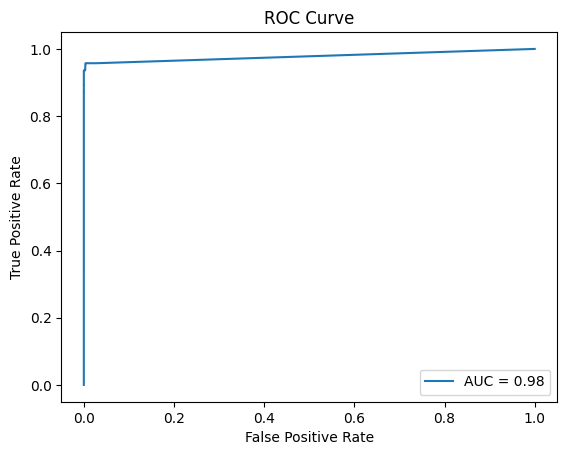

In [18]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


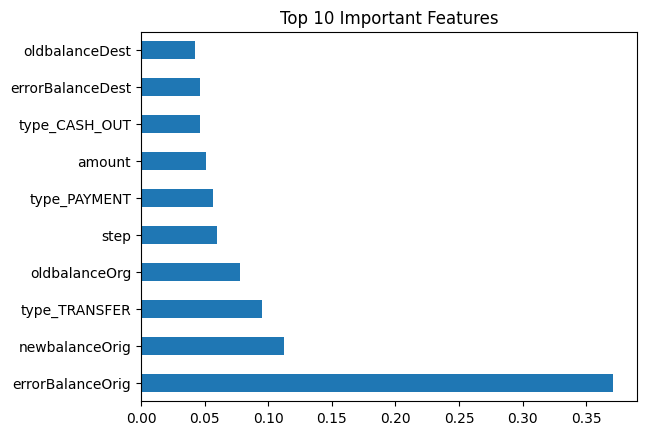

In [19]:
importances = rf.feature_importances_
feat_names = X.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()


### Infrastructure Update & Prevention Strategies

To strengthen the infrastructure against fraudulent activities, the company should implement the following:

- **Real-Time Fraud Detection System**: Integrate ML-based fraud scoring to flag suspicious transactions instantly.
- **Transaction Limits & Alerts**: Flag transactions above a certain threshold and notify the customer.
- **Behavioral Profiling**: Analyze customer behavior patterns to detect anomalies.
- **IP & Geo-Location Verification**: Detect fraud through unusual login locations or device IDs.
- **Multi-Factor Authentication (MFA)**: Especially for high-value or new recipient transfers.
- **Audit Trails & Logging**: Keep detailed logs of every transaction for forensic tracking.

These strategies collectively reduce the risk of fraud and improve trust in the system.


### Validation of Fraud Prevention Action Effectiveness

To evaluate whether the implemented fraud prevention strategies are effective, the following methods should be used:

- **Key Metrics Monitoring**:
  - Reduction in the number of fraudulent transactions
  - Lower false positive and false negative rates
  - Customer complaints and fraud reports

- **A/B Testing**:
  - Implement new fraud systems in a test group and compare against control group.

- **Periodic Model Retraining**:
  - Monitor model performance drift and retrain with updated data.

- **Post-Implementation Feedback Loop**:
  - Analyze flagged transactions to check if the new system caught them effectively.

This helps ensure that the fraud detection system continues to adapt and perform well over time.


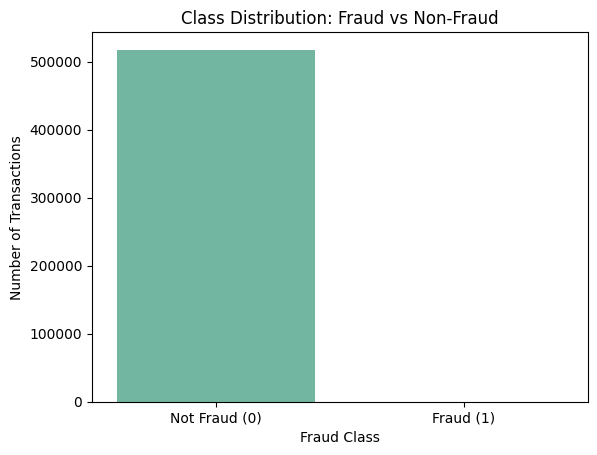

In [21]:
sns.countplot(data=df, x='isFraud', palette='Set2')
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.xlabel('Fraud Class')
plt.ylabel('Number of Transactions')
plt.show()


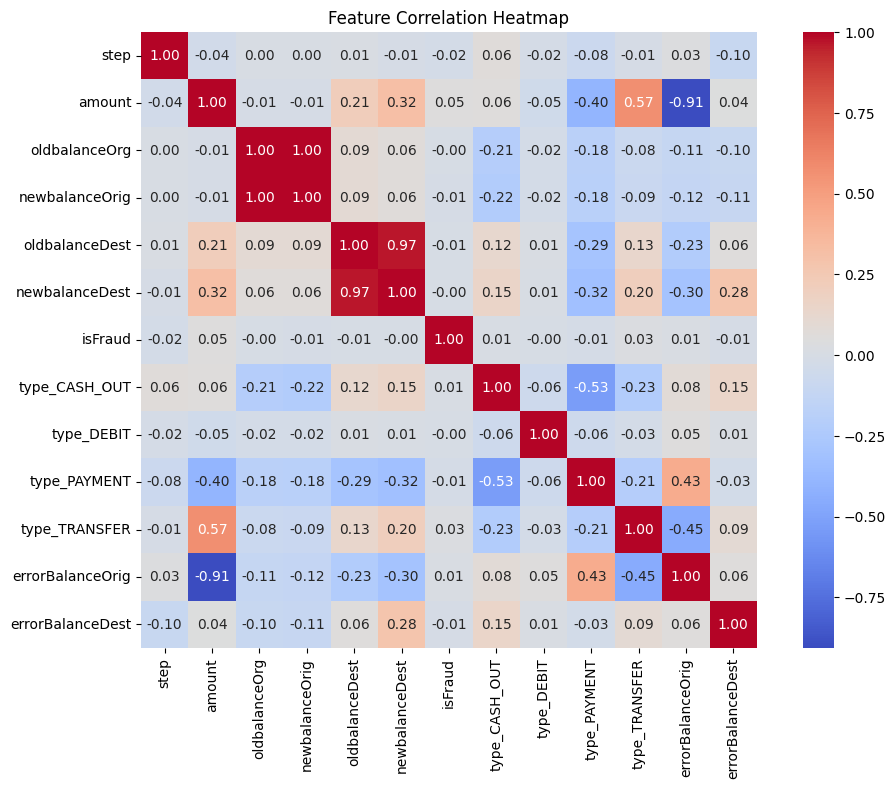

In [22]:
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


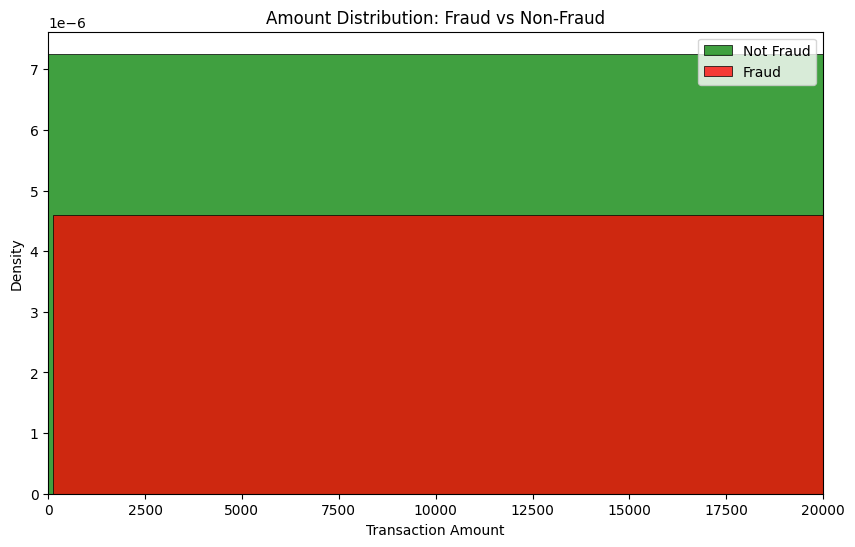

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['isFraud'] == 0], x='amount', bins=100, label='Not Fraud', color='green', stat='density')
sns.histplot(data=df[df['isFraud'] == 1], x='amount', bins=100, label='Fraud', color='red', stat='density')
plt.legend()
plt.xlim(0, 20000)
plt.title('Amount Distribution: Fraud vs Non-Fraud')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.show()


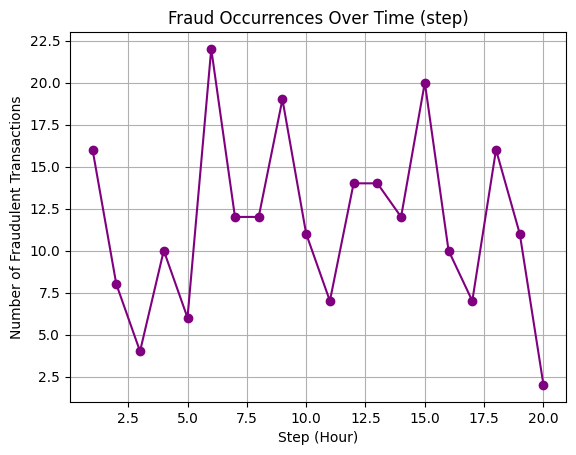

In [24]:
fraud_by_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(fraud_by_step.index, fraud_by_step.values, marker='o', linestyle='-', color='purple')
plt.title('Fraud Occurrences Over Time (step)')
plt.xlabel('Step (Hour)')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid(True)
plt.show()


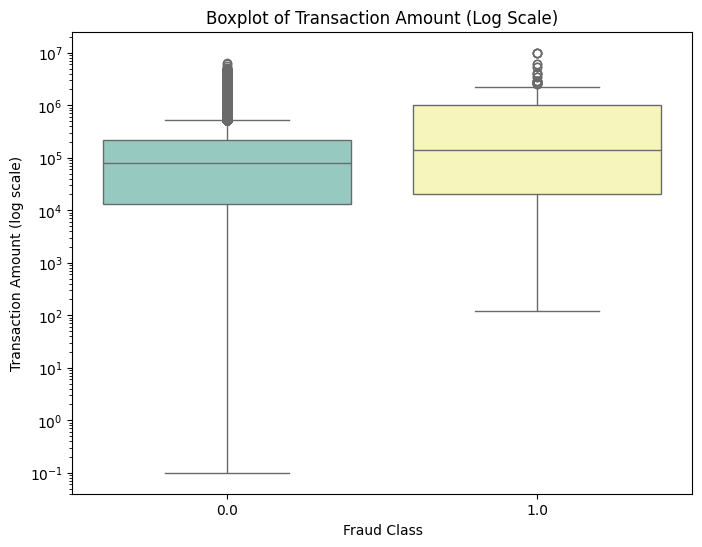

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='amount', data=df, palette='Set3')
plt.yscale('log')
plt.title('Boxplot of Transaction Amount (Log Scale)')
plt.xlabel('Fraud Class')
plt.ylabel('Transaction Amount (log scale)')
plt.show()
